In [318]:
import pandas as pd 
import calendar
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [190]:
df=pd.read_csv("F:\\blocstak_data.csv")

There are **4521** datapoints in this dataset. The dataset is highly imbalanced with **y**'s ratio of unique values being **0.88: 0.12**

In [131]:
print(f"LENGTH OF DATASET: {len(df)}")
print((df.y.value_counts()/len(df)))


LENGTH OF DATASET: 4521
y
no     0.88476
yes    0.11524
Name: count, dtype: float64


In [132]:
df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
5,35,management,single,tertiary,no,747,no,no,cellular,23,feb,141,2,176,3,failure,no
6,36,self-employed,married,tertiary,no,307,yes,no,cellular,14,may,341,1,330,2,other,no
7,39,technician,married,secondary,no,147,yes,no,cellular,6,may,151,2,-1,0,unknown,no
8,41,entrepreneur,married,tertiary,no,221,yes,no,unknown,14,may,57,2,-1,0,unknown,no
9,43,services,married,primary,no,-88,yes,yes,cellular,17,apr,313,1,147,2,failure,no


In [133]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


From the data, some forms of cleaning that seem necessary are:
- The **day** column isnt quite necessary due to the monthly information being readily available.
- The **month** column would be better utilized within a ordinal form of values instead of plain strings.
- The **duration** column needs to be normalized to minutes from seconds due to scale of durations. 
- The **y** variables are better of renamed to result for analysis. We can keep a seperate **y** column for binary values.

In [191]:
# Drop days
df.drop(columns=['day'],inplace=True)
# Normalize duration from aseco0nds to minutes
df['duration'] = df['duration'].apply(lambda n:n/60).round(2)
# Add binarized column
df['result']=df['y'].copy()
df['y'] = df['y'].apply(lambda x: 0 if x == 'no' else 1)
# Create dictionary of months to map to ordinal values
month_list=list(enumerate(calendar.month_name))[1:]
month_dict={key.lower()[:3]:value for value,key in month_list}
# Map month strings to ordinal values
df['month']=df.month.apply(lambda x:month_dict[x])


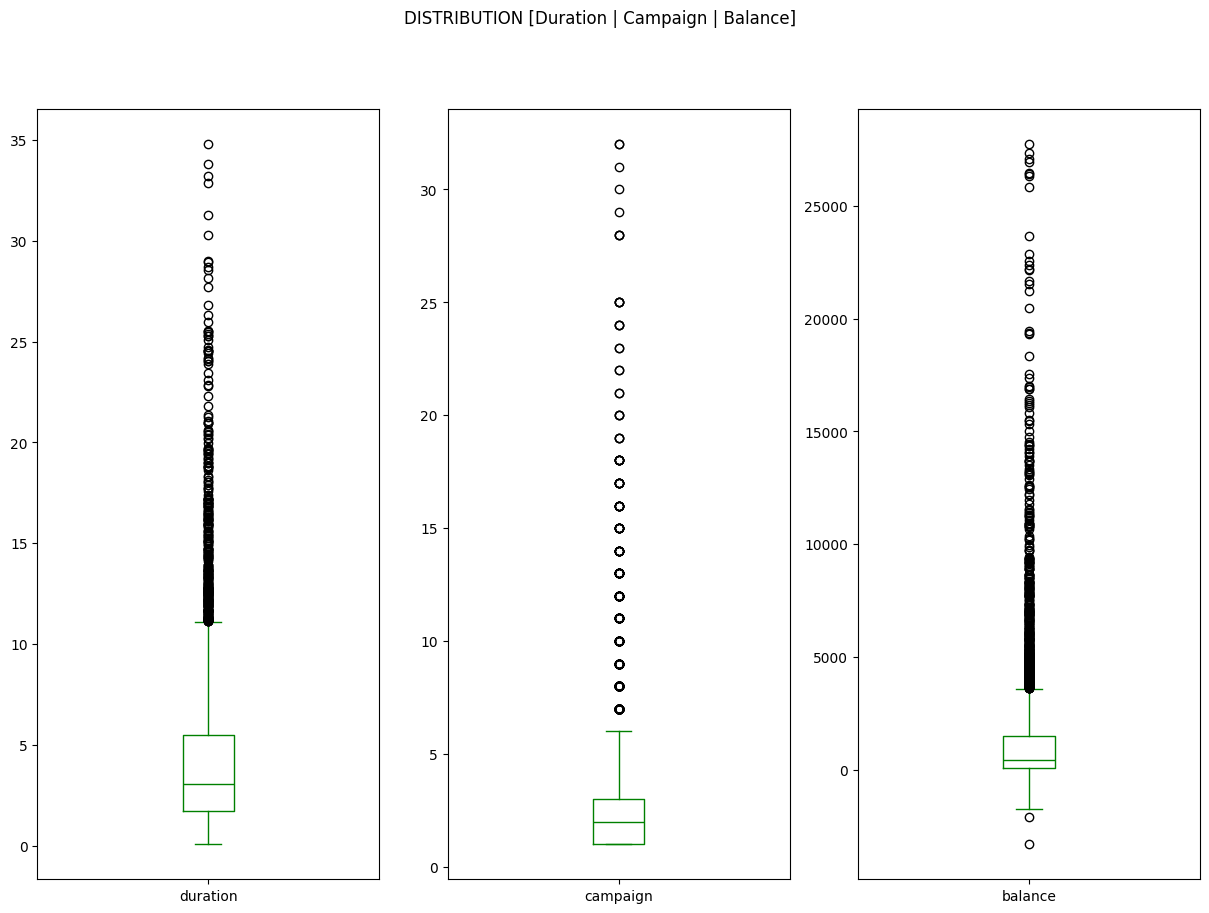

,min,std,mean,median,outlier_count,Q1,Q3,IQR,<1.5*IQR,>1.5*IQR
duration,0.07,4.198564,4.373908,3.08,327.0,1.73,5.48,3.75,-3.895,11.105
campaign,1.00,2.968849,2.774701,2.00,316.0,1.00,3.00,2.00,-2.000,6.000
balance,-3313.00,2761.399401,1398.929774,444.50,504.0,69.00,1477.00,1408.00,-2043.000,3589.000


In [304]:
def get_q_dict(column:pd.Series):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    return {'Q1':Q1,'Q3':Q3,'IQR':IQR}


def outlier_count(column:pd.Series):
    qdict=get_q_dict(column)
    Q1,Q3,IQR=qdict['Q1'],qdict['Q3'],qdict['IQR']
    threshold = 1.5
    outliers = (column < Q1 - threshold * IQR) | (column > Q3 + threshold * IQR)
    return outliers.sum()


#Aggregating data for "Duration", "Campaign", "Balance" columns in the dataset
durcampbal=df[['duration','campaign','balance']].agg(func=['min','std','mean','median',outlier_count],axis='rows').T
q_dict_list=[get_q_dict(df[col]) for col in durcampbal.index]
durcampbal['Q1']=[i['Q1'] for i in q_dict_list]
durcampbal['Q3']=[i['Q3'] for i in q_dict_list]
durcampbal['IQR']=[i['IQR'] for i in q_dict_list]
durcampbal['<1.5*IQR']=durcampbal['Q1']-1.5*durcampbal['IQR']
durcampbal['>1.5*IQR']=durcampbal['Q3']+1.5*durcampbal['IQR']

#Visualizing boxplots and outliers based on observed data
duration_distance_plot = df[['duration','campaign','balance']].plot(kind = 'box', color= 'green',
                                                      figsize = (15,10),
                                                      subplots = True, layout = (1,3),
                                                      sharex = False, sharey = False,
                                                      title='DISTRIBUTION [Duration | Campaign | Balance]')
plt.show()

durcampbal

- **Distribution of Duration**: Observations from table and boxplot indicates the duration of contact had a median of 3 minutes, along with a first quartile of 1.73 minutes with a third quartile of 5.3 minutes spanning a 3.7 minute Inter Quartile Range. The relative left skew in the distribution shows that most calls were on the shorter end with considerable amount of outliers ranging from 11 to 40 minutes. These outliers seem to be key in hunting for marketing leads.
- **Distribution of Campaign**: 25% of the customers were contacted by the bank for the first time, while approximately half of them were contacted for the second time. Most clients were contacted only thrice, however there is a even distribution of outlieres ranging from 5 times to approximately 33 times along with a select few ranging to be as high as 45 to 50 times.
- **Distribution of Balance**: Balance seems to show the highest amount of outliers and is the most left skewed of the three distributions we have seens so far, with values even extending to negatives ranging of considerable magnitude. (Funnily enough, this also goes to represent how the rich keep eating the poor hehe). The standard deviation and high interquartile range represents the high population of outliers as seen in the boxplot. Also, it can be seen that there is probably just a single or two outliers in the 40 thousands' range.
- The extreme outliers on all three distributions need to be dropped for better probabilistic modelling.

In [288]:
extreme_outlier_rows=df[(df.duration>40)|(df.balance>30000)|(df.campaign>40)]

In [289]:
df.drop(extreme_outlier_rows.index,inplace=True)

Age and Balance details: 
               age       balance
count  4514.000000   4514.000000
mean     41.161276   1398.929774
std      10.575681   2761.399401
min      19.000000  -3313.000000
25%      33.000000     69.000000
50%      39.000000    444.500000
75%      49.000000   1477.000000
max      87.000000  27733.000000


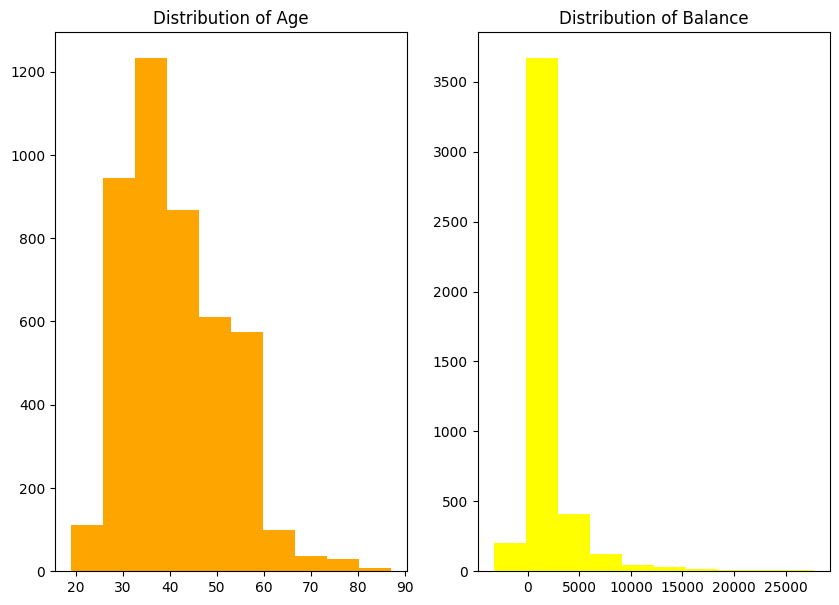

In [327]:
plt.figure(figsize=(10,7))

plt.subplot(1,2,1)
plt.hist(df.age,color='orange')
plt.title("Distribution of Age")
plt.subplot(1,2,2)
plt.hist(df.balance,color='yellow')
plt.title('Distribution of Balance')

print(f"Age and Balance details: \n{df[['age','balance']].describe()}")


- **Distribution of Age**: Majority of clients contacted by bank seem of in their 30s or 40s (The interquartile range of percentiles range from 33 to 48 year olds). Other than this, the distribution is fairly normal.
- **Distribution of Balance**: Despite capping outliers to 30,000 the interquartile range of Balance is still a considerable 1408 euros. The standard deviation for Balance is quite notable, suggesting large variations in customer balances.

In [234]:
df['age_buck']=pd.cut(df.age,bins=[df.age.min(),30,40,50,60,df.age.max()],labels=["=<30","30-40","40-50","50-60",">=60"],right=True)

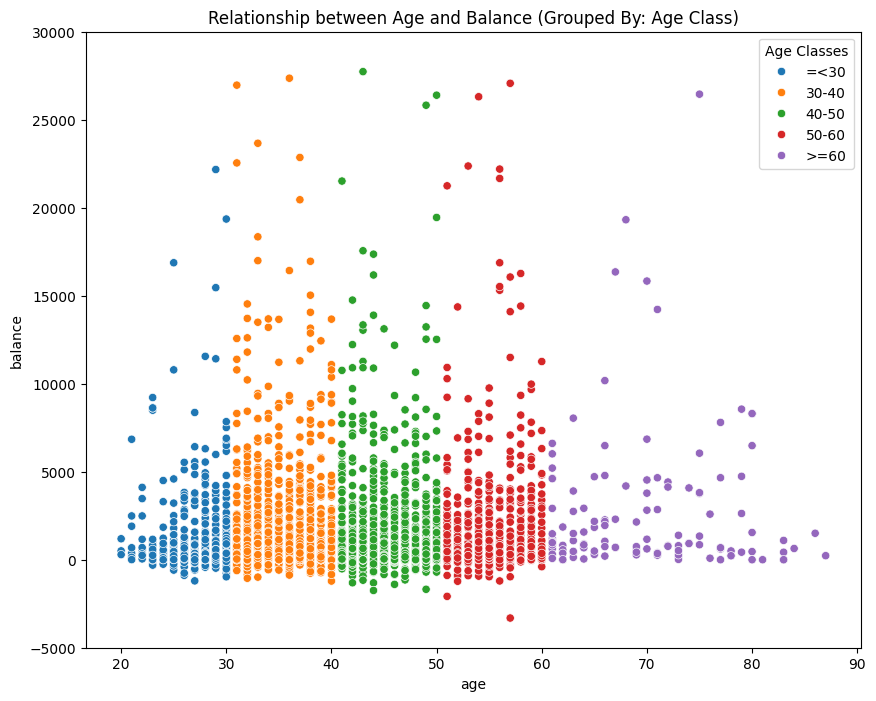

In [307]:
import numpy as np
#Capping our balance to a max of 30000 for extreme outliers
plt.figure(figsize=(10,8))
plt.ylim(-5000,30000)
sns.scatterplot(x='age',y='balance',data=df,hue='age_buck')
plt.title('Relationship between Age and Balance (Grouped By: Age Class)')
plt.legend(title='Age Classes')




From the above diagram, it is safe to conclude that there isnt any notable relationship between **Age** and **Balance** of customers in terms of specific age groups. However, it can be noted that people at 60 and above tend to have lesser balance than younger people, also, people at after 60, tend to have very low negative balances. This could be due to planned funding of expenses that people make due to retirement.

## Duration & Campaign

Text(35, 15, 'Greater Subscription rate when no. of calls <5')

<Figure size 800x1500 with 0 Axes>

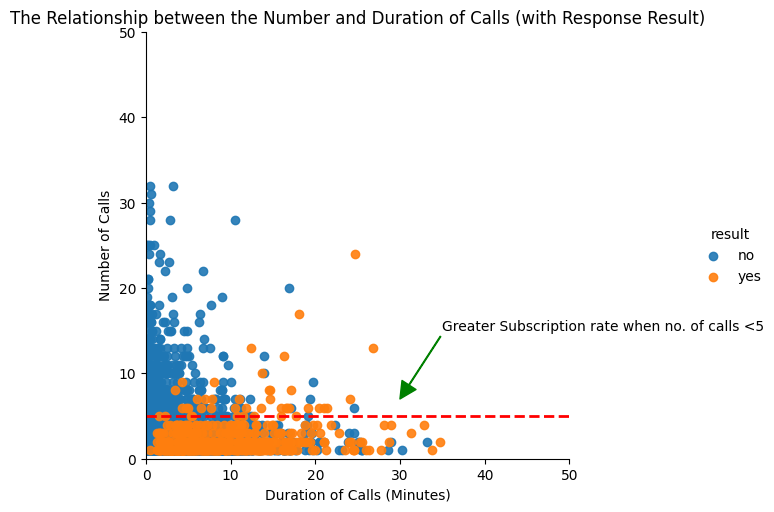

In [358]:
plt.figure(figsize=(8,15))
sns.lmplot(x='duration',y='campaign',data=df,hue='result',fit_reg=False,height=5,scatter_kws={'alpha':0.9})

plt.axis([0,50,0,50])
plt.ylabel('Number of Calls')
plt.xlabel('Duration of Calls (Minutes)')
plt.title('The Relationship between the Number and Duration of Calls (with Response Result)')


plt.axhline(y=5, linewidth=2, color="red", linestyle='--')
plt.annotate("Greater Subscription rate when no. of calls <5", xytext=(35,15), arrowprops=dict(color='green',width=0.5),xy=(30,7))

According to this scatter plot, the datapoints form two clusters in which most datapoints with larger number of contact instances tend to have coversations of lower durations that usually ends up with negative client response. Whereas, most positive responses tend to come from clients who have been contacted fewer times, but have had long, engaging converstions each time he or she was contacted. Clients seem to be more likely to reject the deposit unless conversation is long and engaging or number of times contacted is less than 10.
This suggests that banks should refrain from calling a client more than 5 times as well as making telemarketting conversations more engaging.

In [236]:
response_age_count =pd.crosstab(df['result'],df['age_buck']).transpose()

In [237]:
response_age_count[['no',"yes"]]]

result,no,yes
age_buck,,
=<30,540,88
30-40,1622,178
40-50,1039,123
50-60,718,82
>=60,79,48


In [241]:
df['balance']

0       1787
1       4789
2       1350
3       1476
4          0
        ... 
4516    -333
4517   -3313
4518     295
4519    1137
4520    1136
Name: balance, Length: 4521, dtype: int64